## Accessing Deltares global flood data on Azure

[Deltares](https://www.deltares.nl/en/) has produced a series of global inundation maps of flood depth using a geographic information systems (GIS)-based inundation model that takes into account water level attenuation and is forced by sea level. Multiple datasets were created using various digital elevation models (DEMs) at multiple resolutions under two different sea level rise (SLR) conditions: current (2018) and 2050. 

This notebook provides an example of accessing global flood data from blob storage on Azure.

This dataset is stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in the same region. If you are using this data for environmental science applications, consider applying for an AI for Earth grant to support your compute requirements.

Complete documentation for this dataset is available at https://aka.ms/ai4edata-deltares-gfm.

### Environment setup

In [1]:
# Install a conda package in the current Jupyter kernel
# import sys
# !conda install --yes --prefix {sys.prefix} aiohttp

In [2]:
import math
import warnings

warnings.simplefilter("ignore")

import fsspec
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Not used directly, but needs to be installed to read NetCDF files with xarray
import h5py
import h5netcdf

from dask.distributed import Client

from shapely.geometry import shape
import geopandas as gpd
import pandas as pd
import openpyxl

### Define an area of interest

The data is 90m (3'') at a global scale, but most relevant in coastal areas. Let's zoom in a on a flood-prone region of South Africa (City of Cape Town) by defining a bounding box and clipping our xarray dataset.

In [3]:
coct_geojson = {
    "type": "Polygon",
    "coordinates": [
        [
            [-33.459480262765084, 18.44984306000178],
            [-34.0349865125429, 18.287794733823475],
            [-34.36664252903477, 18.491041786996263],
            [-34.075946082570105, 19.012892328926387]
        ]
    ],
}

poly = shape(coct_geojson)
miny, minx, maxy, maxx = poly.bounds
print("AoI bounds:", poly.bounds)

AoI bounds: (-34.36664252903477, 18.287794733823475, -33.459480262765084, 19.012892328926387)


### Create a local Dask cluster

Enable parallel reads and processing of data using Dask and xarray.

In [4]:
client = Client(processes=False)
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/proxy/8787/status


### File access

The entire dataset is made up of several dozen individual netCDF files, each representing an entire global inundation map, but derived from either a diferent source DEM, sea level rise condition, or return period. Return periods are occurence probabilities for floods of a particular magnitude, often referred to as, for example, "a 100 year flood".

To start, we'll load and plot the inundation data produced from the 90m NASADEM/MERITDEM at a 0/2/5/10/25/100/250 year return period for 2050 sea level rise conditions. 

In [5]:
# We define the set of parameters to iterate over

dem_source_list = ["NASADEM", "MERITDEM"]
return_period_list = ["0000", "0002", "0005", "0010", "0025", "0100", "0250"]

In [6]:
# We now import the reference grid shapefile

grid = gpd.read_file("grid_reference_500.shp")

In [7]:
# And we convert it to the same geographic format at the input flood map
grid_coord = grid.to_crs(4326)

# We also add the area of a pixel and clean the resulting data frame
grid_coord['pixel_area'] = grid_coord.geometry.area
grid_coord = grid_coord.loc[:, ['ID', 'geometry', 'pixel_area']]

### Geographic Treatment

We first adapt the imported data to the desired flood map format, as with CoCT's grid.
Then, we associate to each grid pixel its share of flood-prone area and a flood depth level associated with the relative share of each flood points in this area.

In [8]:
def make_url(year, dem_source, return_period):
    root = (
        "https://deltaresfloodssa.blob.core.windows.net/floods/v2021.06"
    )
    path = f"{root}/global/{dem_source}/90m"
    file_name = f"GFM_global_{dem_source}90m_{year}slr_rp{return_period}_masked.nc"

    return f"{path}/{file_name}"

In [9]:
def geo_treatment(dem_source, return_period, flooded, grid_coord, year):

    # We keep only relevant data from source

    flooded_inun = flooded['inun']
    da = flooded_inun.to_dataframe().reset_index()

    # We convert associated points to a GeoDataFrame for geographic treatment

    gdf = gpd.GeoDataFrame(
        da.inun, geometry=gpd.points_from_xy(da.lon,da.lat), crs="EPSG:4326")

    # We clean the output

    gdf = gdf.loc[~np.isnan(gdf['inun'])]

    # We create a square buffer of side 90m (~0.03*(1/60) degrees in our geometry) around our centroids
    # This corresponds to the resolution of the flood map
    gdf_buffer = gdf.buffer(0.03*(1/60), cap_style=3)

    # We plot the output for validation
    fig, ax1 = plt.subplots()
    gdf_buffer.boundary.plot(ax=ax1, color = 'slategrey')
    gdf.plot(ax = ax1, color = 'red')

    # We update the geometry of out GeoDataFrame with the buffer polygons

    gdf_new = gdf
    gdf_new['geometry'] = gdf_buffer

    # We save the associated shapefile

    gdf_new.to_file(dem_source + '_' + return_period + '.shp')

    # We get the intersection of the two data frames and get the associated area
    grid_overlay = gpd.overlay(gdf_new, grid_coord)
    grid_overlay['inter_area'] = grid_overlay.geometry.area

    # We plot the output for validation
    fig, ax1 = plt.subplots()
    grid_coord.boundary.plot(ax = ax1, color = 'slategrey')
    grid_overlay.boundary.plot(ax=ax1, color = 'red')

    # Note that the grid perimeter is a bit wider than CoCT's territorial extent, hence some coastal
    # points appear to be inland: this is not a problem as sea points have zero land availability
    # in the model

    # We first compute the proportion of flood-prone area in each pixel
    sum_flood_area = grid_overlay.groupby('ID')['inter_area'].agg('sum')
    pixel_area = grid_overlay.groupby('ID')['pixel_area'].agg('mean')
    prop_flood_prone = pd.Series(sum_flood_area / pixel_area, name='prop_flood_prone')
    # The following correction only applies to two pixels (out of 401)
    prop_flood_prone[prop_flood_prone > 1] = 1

    # We then get the flood depth per pixel as a weighted average of flood depth levels in each
    # pixel intersections with original flood data
    grid_overlay['w_inun'] = grid_overlay['inun'] * grid_overlay['inter_area']
    sum_w_inun = grid_overlay.groupby('ID')['w_inun'].agg('sum')
    flood_depth = pd.Series(sum_w_inun / sum_flood_area, name='flood_depth')

    output = pd.merge(flood_depth, prop_flood_prone, on='ID')
    print(output)

    # We merge back the output with CoCT's grid to cover the full extent of the city
    # (not only the flooded pixels)
    
    slr = ""
    if year == 2050:
        slr = "1"
    elif year == 2018:
        slr = "0"
    
    result = pd.merge(grid_coord, output, left_on='ID', right_index=True, how='outer')
    result.to_file("C_" + dem_source + "_" + slr + "_" + return_period + ".shp")

    # We also export the results to the same format as for FATHOM data

    result_export = result.loc[:,['flood_depth', 'prop_flood_prone']]
    result_export.flood_depth[np.isnan(result_export['flood_depth'])] = 0
    result_export.prop_flood_prone[np.isnan(result_export['prop_flood_prone'])] = 0
    result_export.to_excel("C_" + dem_source + "_" + slr + "_" + return_period + ".xlsx", index=False)
    
    return result

### Loop over parameters

       flood_depth  prop_flood_prone
ID                                  
913       0.022341          0.021885
1370      0.133387          0.013894
1522      0.133387          0.027334
3806      0.270104          0.059043
3807      0.425212          0.023349
...            ...               ...
23632     0.529304          0.040832
23716     0.135836          0.081654
23746     0.268543          0.028222
23747     0.268593          0.053431
23880     0.235877          0.122467

[63 rows x 2 columns]
       flood_depth  prop_flood_prone
ID                                  
913       1.265686          0.047990
1065      0.509894          0.036740
1369      0.280704          0.041230
1370      1.249815          0.055124
1522      0.870811          0.068562
...            ...               ...
23936     0.422091          0.159495
23937     0.325489          0.126246
23938     0.206814          0.040820
23946     0.192742          0.008451
23947     0.192742          0.029967

[281 rows x 2 

2023-04-27 11:53:02,510 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-27 11:53:02,721 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-04-27 11:53:02,916 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


       flood_depth  prop_flood_prone
ID                                  
761       0.111716          0.012386
913       1.339924          0.056395
1065      0.799226          0.036740
1217      0.090867          0.033416
1369      0.493673          0.049046
...            ...               ...
23946     0.153647          0.049271
23947     0.481512          0.029967
23970     0.118792          0.020358
23971     0.118792          0.020460
23997     0.120215          0.040818

[345 rows x 2 columns]


2023-04-27 11:53:13,731 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-04-27 11:53:14,137 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-04-27 11:53:24,452 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-27 11:53:24,624 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-27 11:53:24,822 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-27 11:53:25,021 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


       flood_depth  prop_flood_prone
ID                                  
761       0.270559          0.012386
913       0.935421          0.095253
1065      0.906990          0.039118
1217      0.249711          0.033416
1369      0.652517          0.049046
...            ...               ...
23946     0.312168          0.049271
23947     0.640033          0.029967
23970     0.279949          0.020358
23971     0.279949          0.020460
23997     0.191921          0.081636

[373 rows x 2 columns]


2023-04-27 11:53:35,776 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-04-27 11:53:36,299 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-04-27 11:53:41,215 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-04-27 11:53:41,387 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-04-27 11:53:41,571 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-04-27 11:53:41,818 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


       flood_depth  prop_flood_prone
ID                                  
761       0.375564          0.012386
913       1.040425          0.095253
1065      1.011995          0.039118
1217      0.354715          0.033416
1369      0.757521          0.049046
...            ...               ...
23946     0.416954          0.049271
23947     0.744819          0.029967
23970     0.386360          0.020358
23971     0.386360          0.020460
23997     0.296708          0.081636

[391 rows x 2 columns]


2023-04-27 11:53:53,017 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-04-27 11:54:03,594 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-04-27 11:54:03,792 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-04-27 11:54:04,021 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-04-27 11:54:04,906 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


       flood_depth  prop_flood_prone
ID                                  
913       0.245383          0.043499
2282      0.255300          0.003341
2283      0.255300          0.037876
7023      0.322996          0.001216
7024      0.322996          0.001579
...            ...               ...
23812     0.004687          0.040824
23908     0.396491          0.040823
23917     0.695695          0.081641
23936     0.169327          0.123968
23937     0.004687          0.080133

[125 rows x 2 columns]


2023-04-27 11:54:14,401 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-04-27 11:54:25,452 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-04-27 11:54:25,645 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-04-27 11:54:25,832 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-04-27 11:54:26,052 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


       flood_depth  prop_flood_prone
ID                                  
913       1.267262          0.086854
1065      0.724304          0.099498
1217      0.452992          0.095871
1218      0.554051          0.008677
1369      0.600926          0.041230
...            ...               ...
23971     0.032085          0.020461
23987     0.868679          0.025906
23997     0.077426          0.023644
23998     0.077426          0.017174
23999     0.587429          0.040818

[332 rows x 2 columns]


2023-04-27 11:54:35,996 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-04-27 11:54:36,897 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-04-27 11:54:47,411 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-04-27 11:54:47,599 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-04-27 11:54:47,814 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-04-27 11:54:48,060 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


       flood_depth  prop_flood_prone
ID                                  
913       1.372216          0.086854
1065      0.829258          0.099498
1217      0.557946          0.095871
1218      0.644326          0.008876
1369      0.705880          0.041230
...            ...               ...
23971     0.091905          0.040997
23987     0.973433          0.025906
23997     0.182180          0.023644
23998     0.182180          0.017174
23999     0.692183          0.040818

[345 rows x 2 columns]


2023-04-27 11:54:58,853 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-04-27 11:55:09,462 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-04-27 11:55:09,650 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-27 11:55:09,881 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


       flood_depth  prop_flood_prone
ID                                  
913       1.451618          0.086854
1065      0.908661          0.099498
1217      0.637349          0.095871
1218      0.723728          0.008876
1369      0.785282          0.041230
...            ...               ...
23971     0.172623          0.040997
23987     0.445718          0.066724
23997     0.261428          0.023644
23998     0.261428          0.017174
23999     0.771431          0.040818

[364 rows x 2 columns]


2023-04-27 11:55:20,367 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-04-27 11:55:21,073 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-27 11:55:30,733 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-04-27 11:55:30,958 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-04-27 11:55:31,207 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


       flood_depth  prop_flood_prone
ID                                  
913       1.556593          0.086854
1065      1.013636          0.099498
1217      0.742324          0.095871
1218      0.828704          0.008876
1369      0.890257          0.041230
...            ...               ...
23971     0.279250          0.040997
23987     0.550486          0.066724
23997     0.366196          0.023644
23998     0.366196          0.017174
23999     0.876198          0.040818

[388 rows x 2 columns]


2023-04-27 11:55:42,146 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-27 11:55:53,703 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-27 11:55:53,885 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-27 11:55:54,094 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-27 11:55:54,325 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


       flood_depth  prop_flood_prone
ID                                  
913       1.715437          0.086854
1065      1.172479          0.099498
1217      0.901167          0.095871
1218      0.987547          0.008876
1369      1.049100          0.041230
...            ...               ...
23971     0.440407          0.040997
23987     0.709007          0.066724
23997     0.524717          0.023644
23998     0.524717          0.017174
23999     1.034719          0.040818

[407 rows x 2 columns]


2023-04-27 11:56:05,169 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-27 11:56:09,879 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-27 11:56:10,093 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-27 11:56:10,341 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


       flood_depth  prop_flood_prone
ID                                  
913       1.820441          0.086854
1065      1.277484          0.099498
1217      1.006172          0.095871
1218      1.092552          0.008876
1369      1.154105          0.041230
...            ...               ...
23971     0.546818          0.040997
23987     0.813793          0.066724
23997     0.235135          0.064462
23998     0.629503          0.017174
23999     1.139505          0.040818

[419 rows x 2 columns]


2023-04-27 11:56:21,107 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-27 11:56:21,908 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-27 11:56:32,147 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-27 11:56:32,365 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-27 11:56:32,637 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


       flood_depth  prop_flood_prone
ID                                  
913       0.125750          0.043496
1370      0.333395          0.013894
1522      0.333395          0.027334
2131      0.132006          0.016504
2283      0.132006          0.024714
...            ...               ...
23632     0.729652          0.040832
23716     0.336185          0.081654
23746     0.270590          0.056446
23747     0.284222          0.106861
23880     0.436226          0.122467

[94 rows x 2 columns]


2023-04-27 11:56:52,496 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-04-27 11:56:52,715 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-27 11:56:52,934 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-27 11:56:53,221 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


       flood_depth  prop_flood_prone
ID                                  
761       0.022392          0.012386
913       1.250600          0.056395
1065      0.709902          0.036740
1217      0.001543          0.033416
1369      0.404349          0.049046
...            ...               ...
23946     0.393091          0.008451
23947     0.393091          0.029967
23970     0.025016          0.020358
23971     0.025016          0.020460
23997     0.031794          0.040818

[326 rows x 2 columns]


2023-04-27 11:57:14,442 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-04-27 11:57:14,694 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-04-27 11:57:14,926 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


       flood_depth  prop_flood_prone
ID                                  
761       0.127346          0.012386
913       1.355554          0.056395
1065      0.814856          0.036740
1217      0.106497          0.033416
1369      0.509303          0.049046
...            ...               ...
23946     0.169980          0.049271
23947     0.497845          0.029967
23970     0.131795          0.020358
23971     0.131795          0.020460
23997     0.136548          0.040818

[343 rows x 2 columns]


2023-04-27 11:57:25,540 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-04-27 11:57:35,209 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-04-27 11:57:35,438 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-04-27 11:57:35,703 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-04-27 11:57:37,028 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


       flood_depth  prop_flood_prone
ID                                  
761       0.206748          0.012386
913       0.871610          0.095253
1065      0.843180          0.039118
1217      0.185900          0.033416
1369      0.588706          0.049046
...            ...               ...
23946     0.249228          0.049271
23947     0.577093          0.029967
23970     0.212513          0.020358
23971     0.212513          0.020460
23997     0.128982          0.081636

[358 rows x 2 columns]


2023-04-27 11:57:46,823 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-27 11:57:56,092 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-27 11:57:56,416 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-27 11:57:56,753 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


       flood_depth  prop_flood_prone
ID                                  
761       0.311723          0.012386
913       0.976585          0.095253
1065      0.948155          0.039118
1217      0.290875          0.033416
1369      0.693681          0.049046
...            ...               ...
23946     0.353996          0.049271
23947     0.681860          0.029967
23970     0.319141          0.020358
23971     0.319141          0.020460
23997     0.233749          0.081636

[381 rows x 2 columns]


2023-04-27 11:58:18,454 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-27 11:58:18,704 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-04-27 11:58:18,968 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


       flood_depth  prop_flood_prone
ID                                  
761       0.470566          0.012386
913       1.135428          0.095253
1065      1.106998          0.039118
1217      0.449718          0.033416
1369      0.852524          0.049046
...            ...               ...
23947     0.840381          0.029967
23970     0.480298          0.020358
23971     0.480298          0.020460
23997     0.308938          0.105282
23998     0.021239          0.017172

[401 rows x 2 columns]


2023-04-27 11:58:29,504 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-04-27 11:58:39,125 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-04-27 11:58:39,391 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-27 11:58:39,694 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


       flood_depth  prop_flood_prone
ID                                  
761       0.575571          0.012386
913       1.240433          0.095253
1065      0.843140          0.058265
1217      0.369618          0.055501
1369      0.957529          0.049046
...            ...               ...
23947     0.855930          0.033399
23970     0.586708          0.020358
23971     0.586708          0.020460
23997     0.319639          0.146100
23998     0.066928          0.057990

[410 rows x 2 columns]


2023-04-27 11:58:50,688 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-04-27 11:59:02,252 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-04-27 11:59:02,501 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-04-27 11:59:03,511 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


       flood_depth  prop_flood_prone
ID                                  
913       0.445390          0.043499
2282      0.455308          0.003341
2283      0.455308          0.037876
3041      0.009998          0.041207
3806      0.171953          0.041196
...            ...               ...
23934     0.064411          0.024535
23936     0.328272          0.159492
23937     0.203719          0.085429
23946     0.141958          0.009418
23947     0.141958          0.033398

[152 rows x 2 columns]


2023-04-27 11:59:13,716 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-04-27 11:59:24,422 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-04-27 11:59:24,720 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


       flood_depth  prop_flood_prone
ID                                  
913       1.467269          0.086854
1065      0.924312          0.099498
1217      0.653000          0.095871
1218      0.739380          0.008876
1369      0.800933          0.041230
...            ...               ...
23971     0.185474          0.040997
23987     0.462065          0.066724
23997     0.277775          0.023644
23998     0.277775          0.017174
23999     0.787777          0.040818

[366 rows x 2 columns]


2023-04-27 11:59:35,150 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-04-27 11:59:46,432 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-04-27 11:59:46,714 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-04-27 11:59:47,025 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


       flood_depth  prop_flood_prone
ID                                  
913       1.572223          0.086854
1065      1.029266          0.099498
1217      0.757954          0.095871
1218      0.844334          0.008876
1369      0.905887          0.041230
...            ...               ...
23971     0.292254          0.040997
23987     0.566819          0.066724
23997     0.382529          0.023644
23998     0.382529          0.017174
23999     0.892531          0.040818

[391 rows x 2 columns]
       flood_depth  prop_flood_prone
ID                                  
913       1.651626          0.086854
1065      1.108668          0.099498
1217      0.837356          0.095871
1218      0.923736          0.008876
1369      0.985290          0.041230
...            ...               ...
23971     0.372972          0.040997
23987     0.646067          0.066724
23997     0.461777          0.023644
23998     0.461777          0.017174
23999     0.971779          0.040818

[399 rows x 2

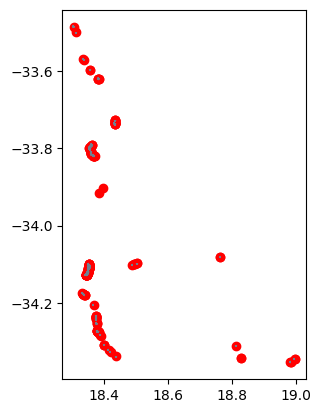

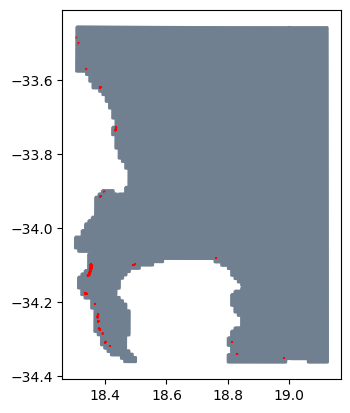

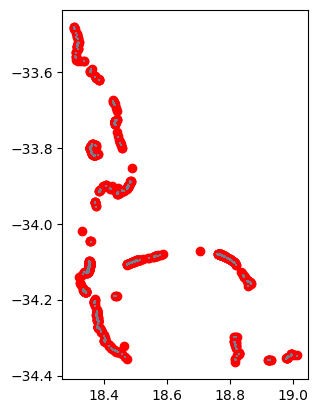

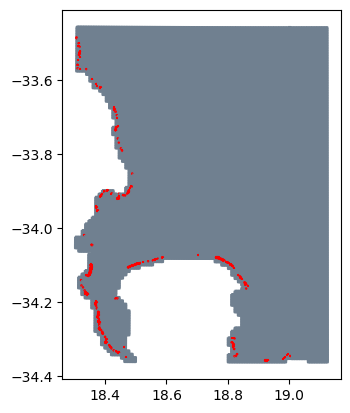

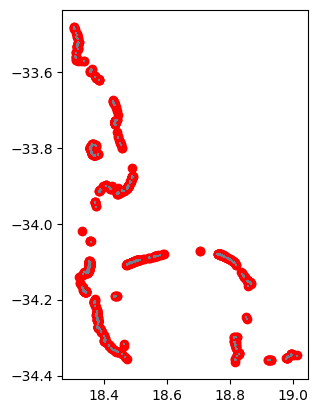

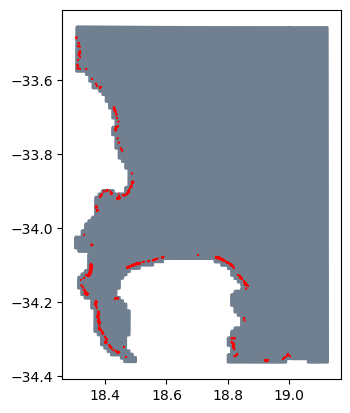

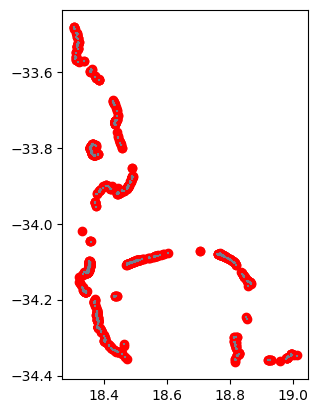

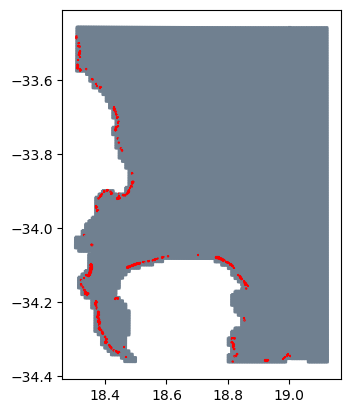

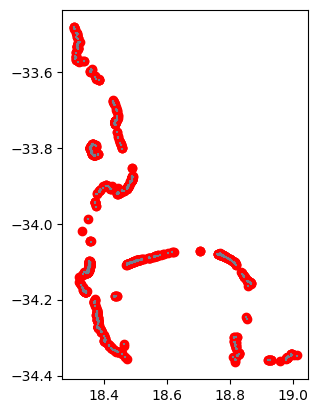

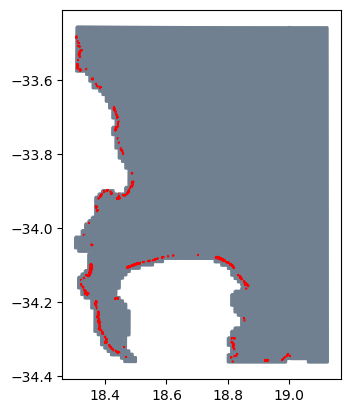

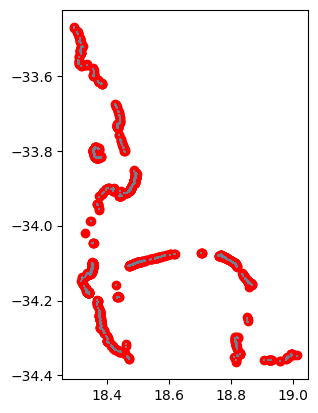

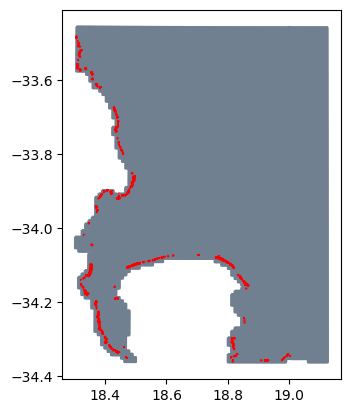

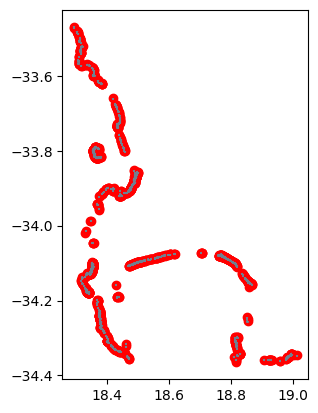

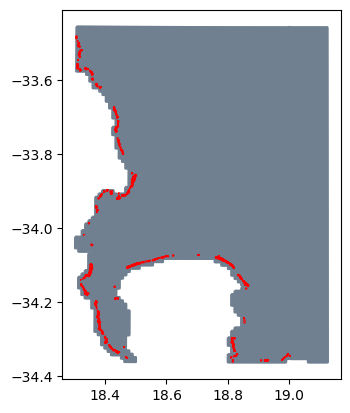

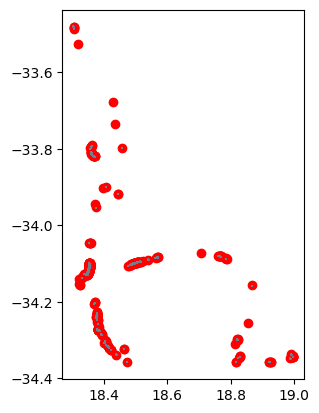

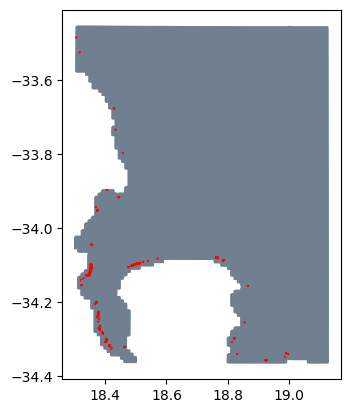

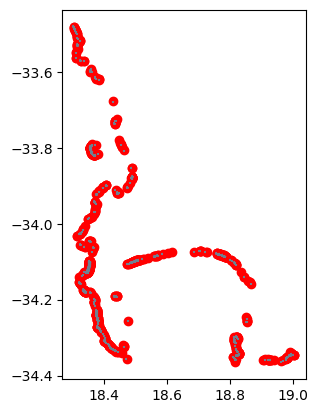

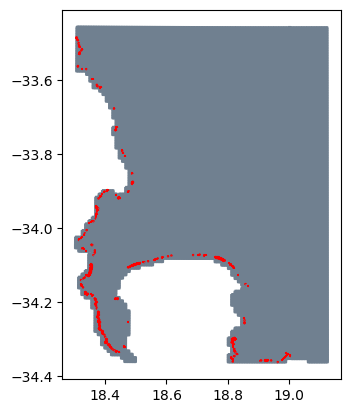

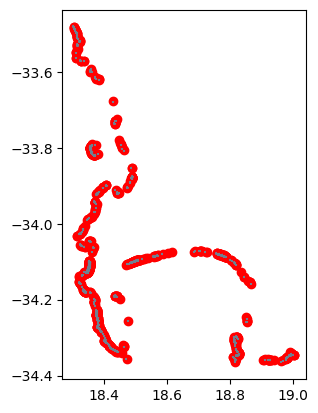

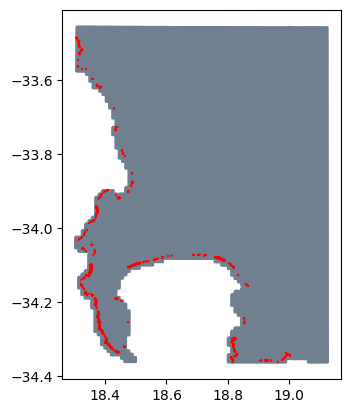

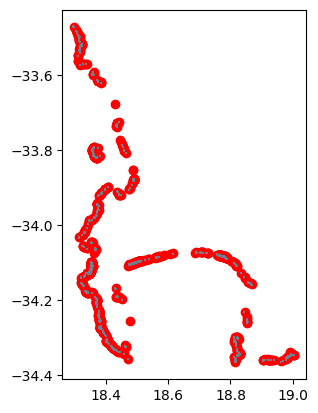

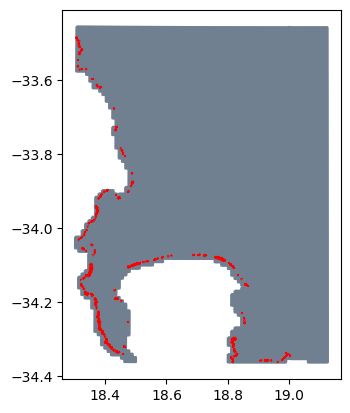

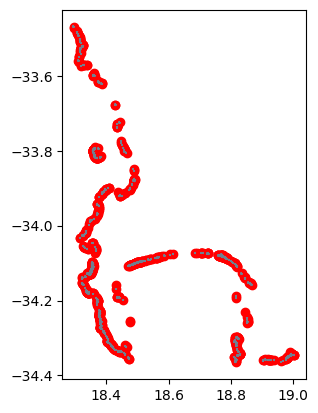

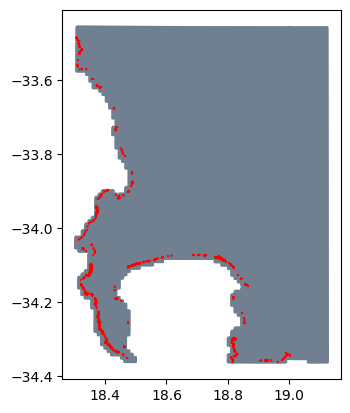

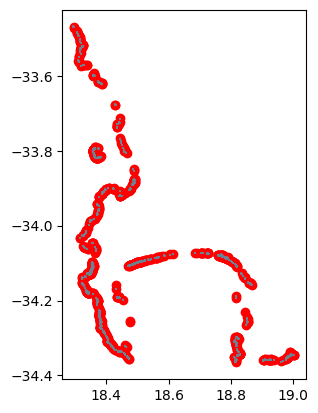

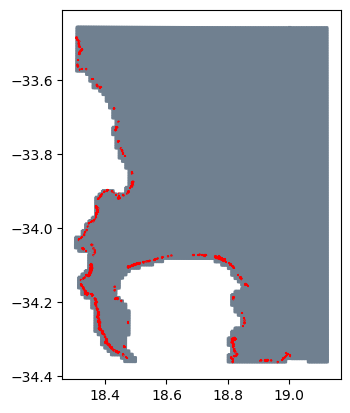

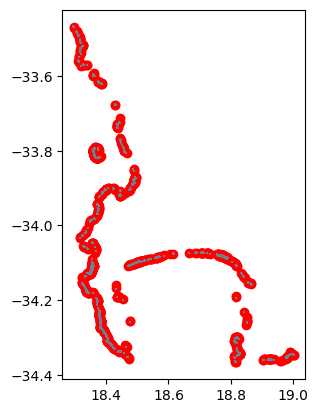

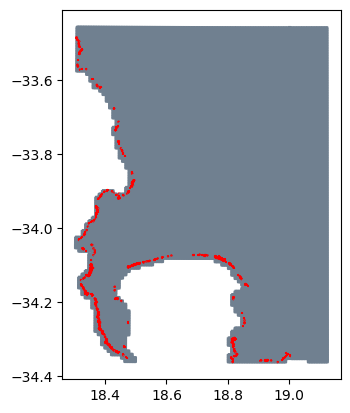

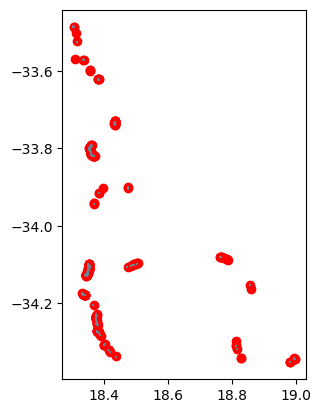

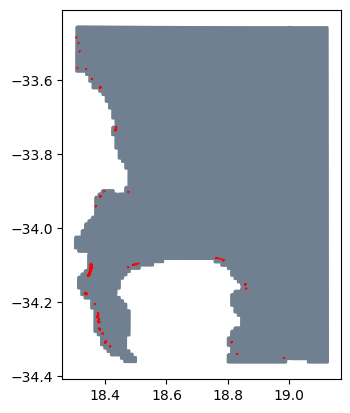

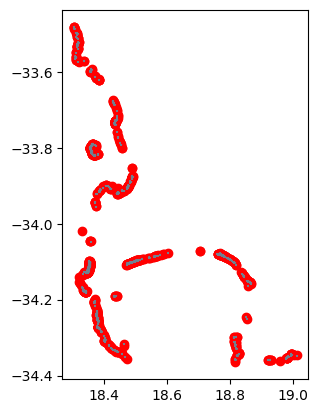

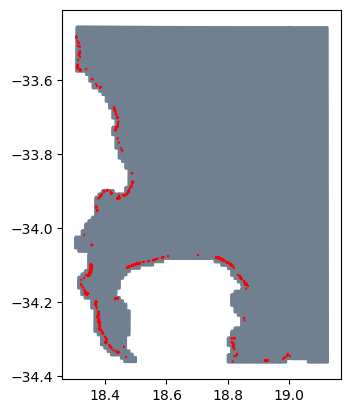

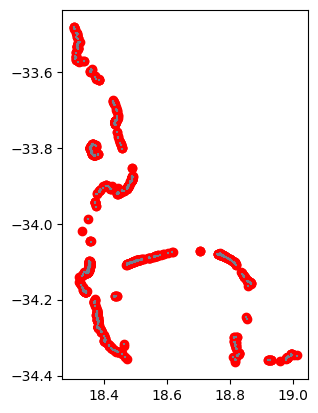

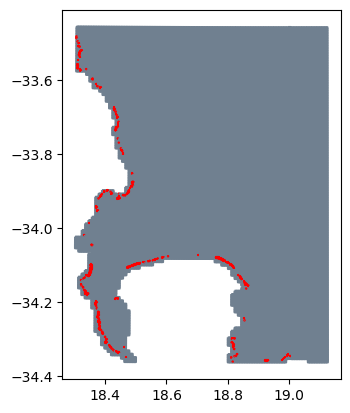

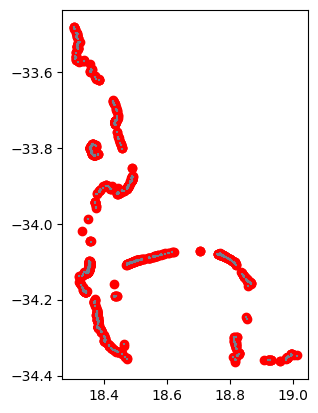

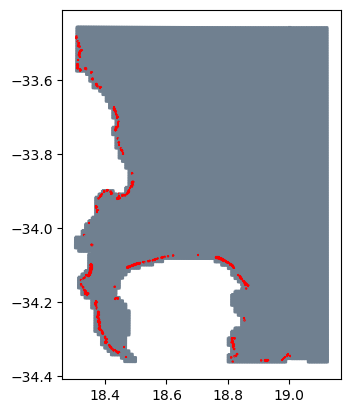

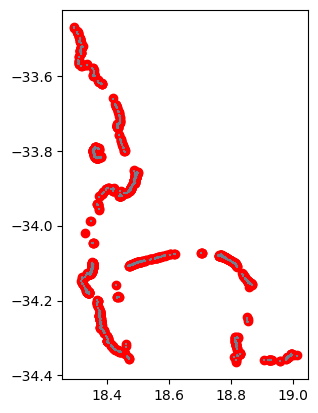

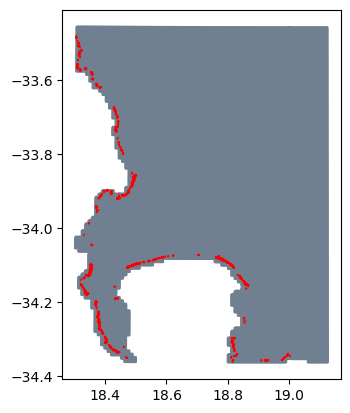

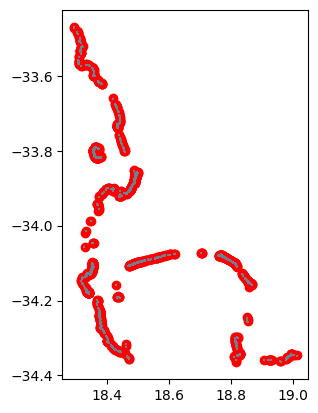

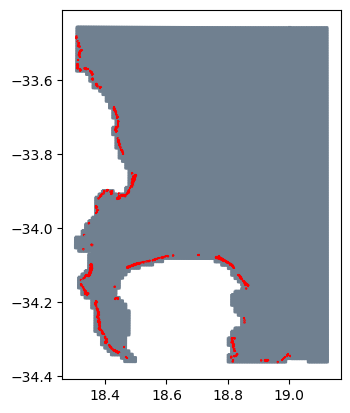

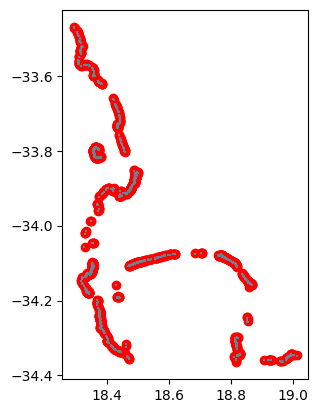

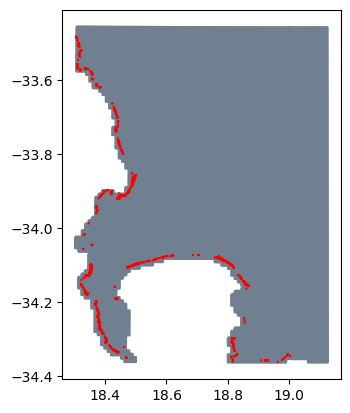

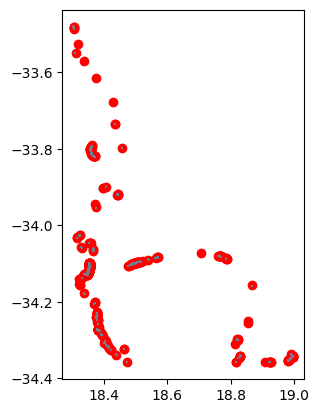

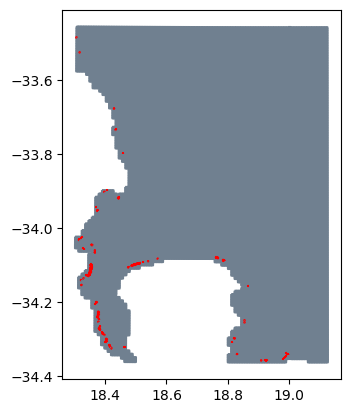

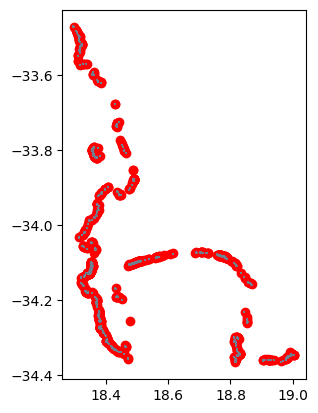

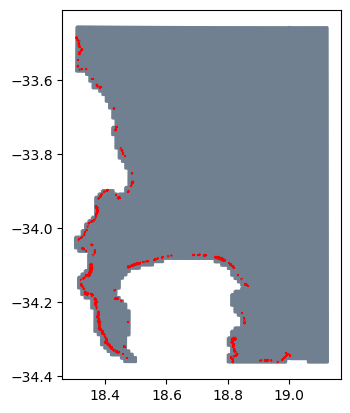

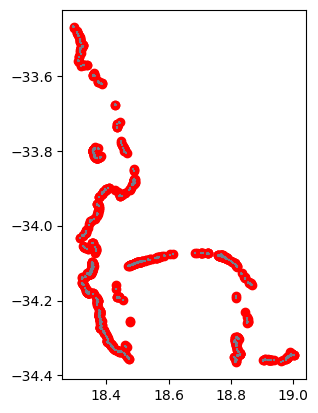

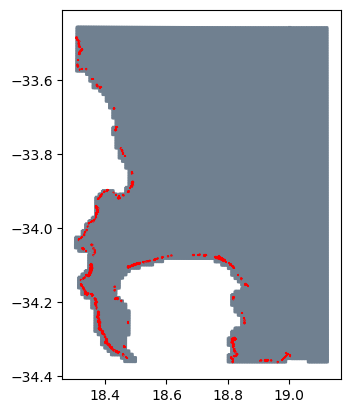

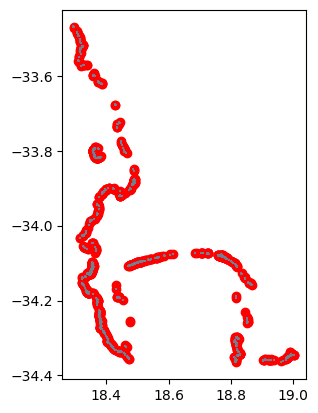

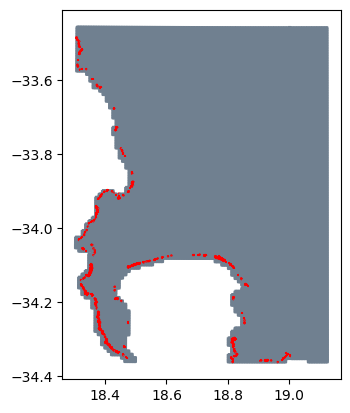

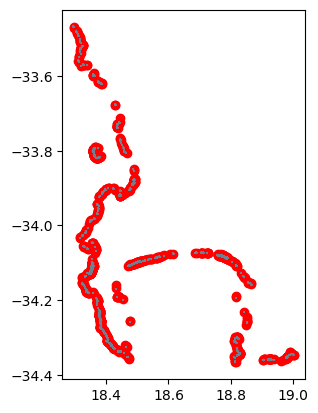

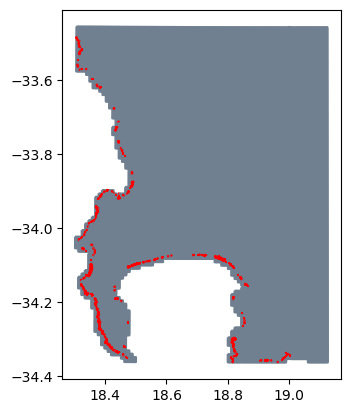

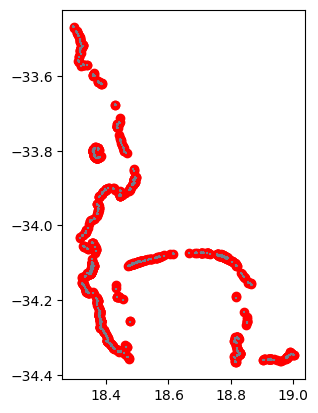

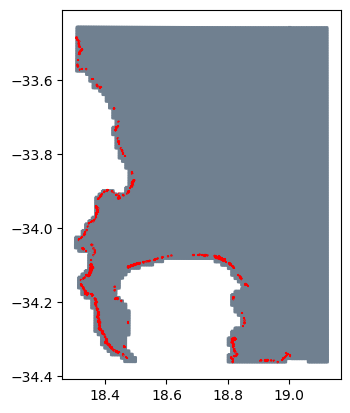

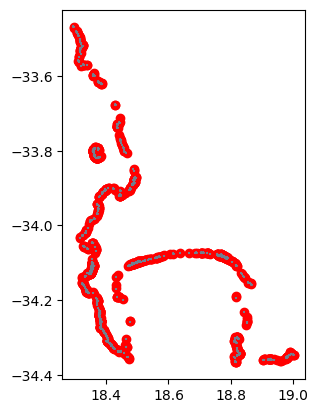

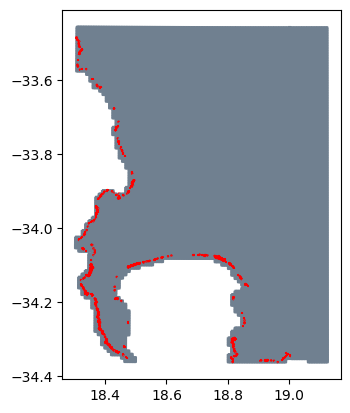

In [10]:
results = []
i = 0

for year in [2018, 2050]:
    for dem_source in dem_source_list:
        for return_period in return_period_list:
        
            with fsspec.open(make_url(year, dem_source, return_period)) as f:
                ds = xr.open_dataset(f, chunks={"lat": 5000, "lon": 5000})
                ds_coct = ds.sel(lat=slice(miny, maxy), lon=slice(minx, maxx))
                # Select only flooded area
                flooded = ds_coct.where(ds_coct.inun > 0).isel(time=0).compute()
            result = geo_treatment(dem_source, return_period, flooded, grid_coord, year)
            results.append(result)

            i = i + 1